In [30]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [31]:
# Other Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import networkx as nx
from copy import deepcopy
from time import sleep, time


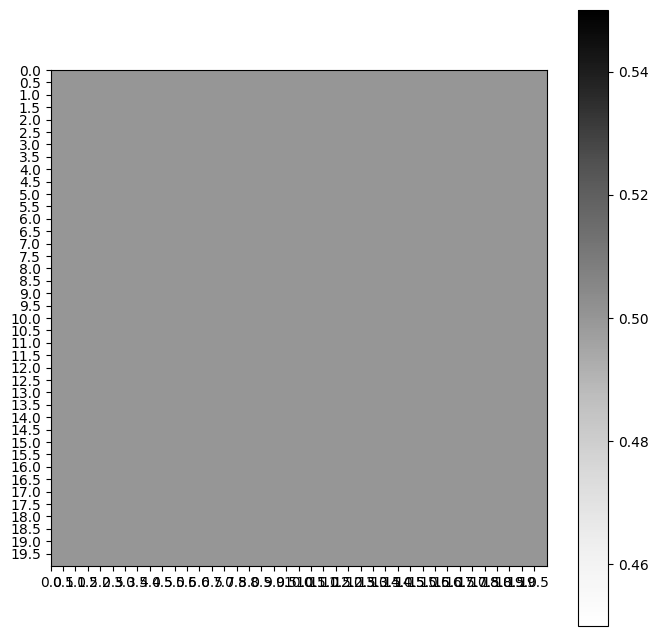

In [32]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

map_size = np.array([10, 10])
cell_size = 0.5

rows, cols = (map_size/cell_size).astype(int)

m = np.full((rows, cols), 0.5)

plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

plt.colorbar()

In [33]:
clientID = RemoteAPIClient()
sim = clientID.require('sim')
sim.setStepping(True)

0

In [34]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id, sim.simx_opmode_streaming)
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id)

    # print(range_data_signal_id)
    resultCodeRanges = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    # returnCodeAngles, string_angle_data = sim.simxGetStringSignal(angle_data_signal_id, sim.simx_opmode_blocking)
    
    resultCodeAngles = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if resultCodeRanges != None and resultCodeAngles != None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(resultCodeRanges)
        raw_angle_data = sim.unpackFloatTable(resultCodeAngles)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None


In [35]:
! pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [36]:
def defineGoal(m):
    for i in range (0,10):
        for j in range (0, 10):
            if(m[i][j] > 0.3):
                return np.array([i, j, np.deg2rad(90)])

In [37]:

from skimage.draw import line

def draw_laser_data_World_Ref(new_point, laser_data, max_sensor_range=5, ax = None):
    
    if (ax == None):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            p = np.zeros((4, 1))
            
            # Eixo x
            p[0] = dist * np.cos(ang)
            # Eixo y
            p[1] = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'

            # Eixo Z, como é 2D o valor pode ser zero
            # p[2] = 0
            # Perspectiva
            p[3] = 1

            xi, yi = np.floor((1/cell_size)*np.array([p[0], p[1]])).astype(int)
            xoi, yoi = np.floor((1/cell_size)*np.array([new_point[0], new_point[1]])).astype(int)
            m[yoi][xoi] = 1

            line_bresenham = np.zeros((rows, cols), dtype=np.uint8)

            yi = yi[0]
            xi = xi[0]

            rr, cc = line(yi, xi, yoi, xoi) # r0, c0, r1, c1

            line_bresenham[rr, cc] = 1
                 
            for j in range(len(rr)):
                if(m[rr[j]][cc[j]] != 1):
                    m[rr[j]][cc[j]] = 0

    ax.plot(new_point[0], new_point[1], 'o', color=c)

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    ax.imshow(m, cmap='Greys', extent=(0, cols, rows, 0))
    ax.imshow(line_bresenham, cmap='Reds', extent=(0, cols, rows, 0), alpha=.5)

    ax.set_xticks(np.arange(0, cols, cell_size))
    ax.set_yticks(np.arange(0, rows, cell_size))


    ax.plot([p[0]/cell_size, [new_point[0]/cell_size]], [p[1]/cell_size, [new_point[1]/cell_size]], 'r-', linewidth=3)




Program started
Connected to remote API server
[5.012112129249349, 1.0710576147762159, 0.06086944655060435]
[5.0051598639226285, 1.070934624601903, 0.06082339403410471]
[4.985445761762443, 1.0705942975619087, 0.06077231755559061]
[4.955362916334996, 1.070153570093296, 0.060669320923651716]
[4.92453731223053, 1.0700602412068867, 0.060604438049320974]
[4.894083690493028, 1.0703238959227255, 0.06060273592419668]
[4.863712106896131, 1.0710078995007413, 0.06071221578785757]
[4.833654848970468, 1.0720436396569495, 0.06079413753675821]
[4.803944474678129, 1.0734253797685023, 0.060881593998870075]
[4.774345720128293, 1.0751495789269585, 0.06086353622130882]
[4.745083741302784, 1.0772096349190097, 0.060755664448085285]
[4.7164262335269544, 1.0795397110258698, 0.06067412546523832]
[4.688105892270984, 1.0821640369527126, 0.06063435919727066]
[4.659821482192841, 1.0851117817421536, 0.06070501085541247]
[4.631872345412706, 1.0883359402781703, 0.0607884417471929]
[4.604369891362018, 1.09181715051468

/var/folders/n8/gppbm48n3hv9s8wfv428y3180000gn/T/ipykernel_81190/2285128127.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,8), dpi=100)


[4.44529334802953, 1.1178618735727892, 0.06069196362285998]
[4.419858257079043, 1.122940899806507, 0.060776806769829904]
[4.394813583570745, 1.1282044364411385, 0.06084869675387696]
[4.369895733177465, 1.1337037502082783, 0.060861072788219284]
[4.3451775973203395, 1.1393838655938415, 0.06084016085223871]
[4.320921038551726, 1.1452097249736712, 0.06081948551278221]
[4.297131487873509, 1.1511612613442983, 0.06076914922950113]
[4.273537691315701, 1.1572637953173452, 0.060679355872939544]
[4.250137048320252, 1.1635507507540228, 0.06067782319027952]


KeyboardInterrupt: 

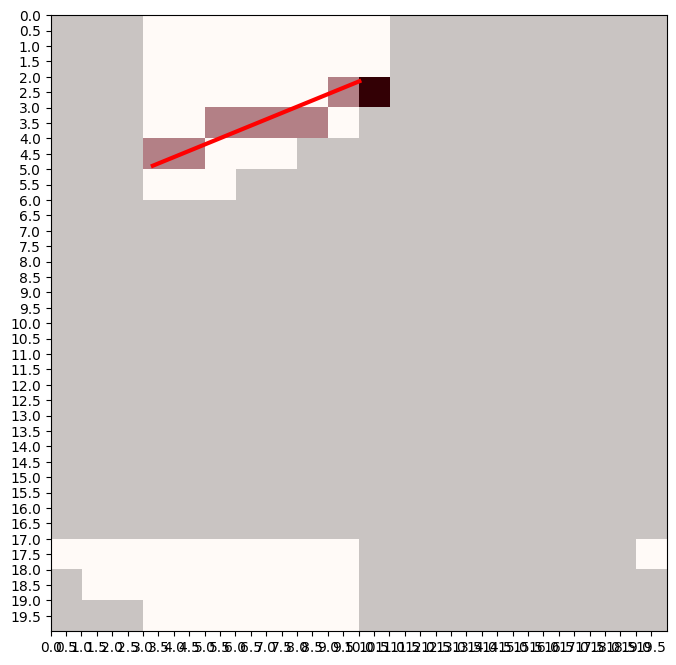

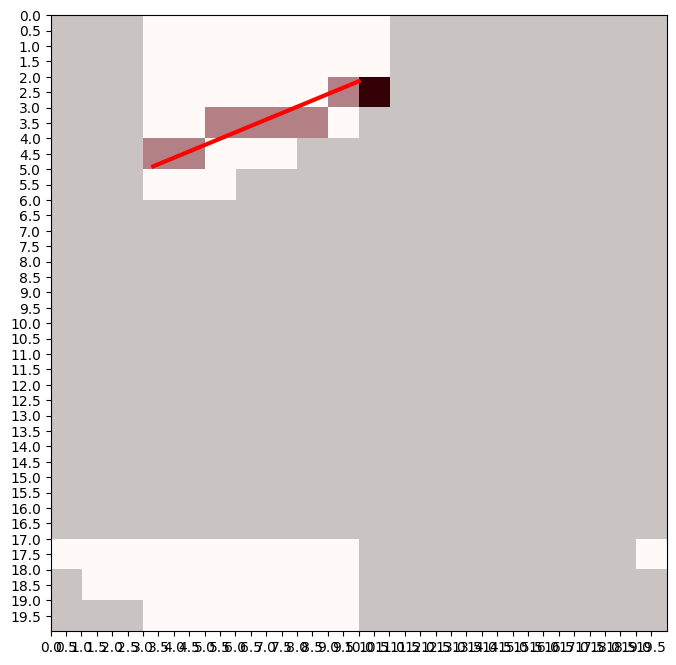

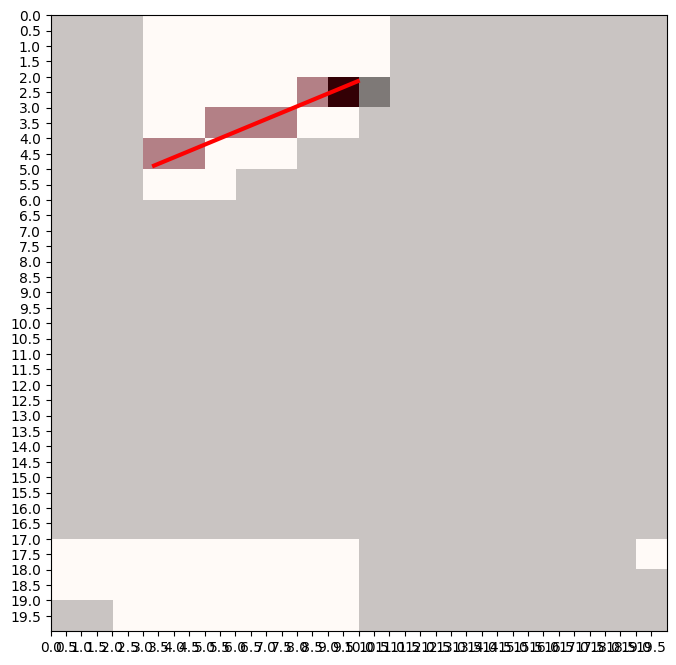

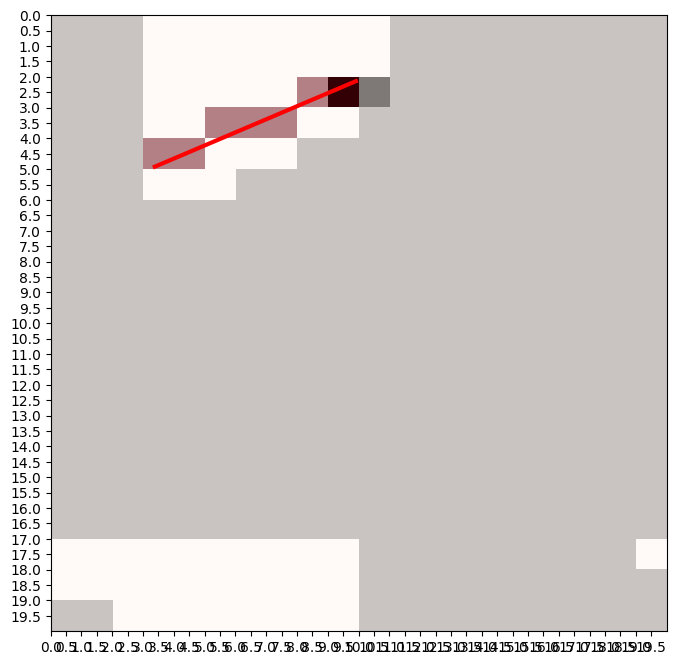

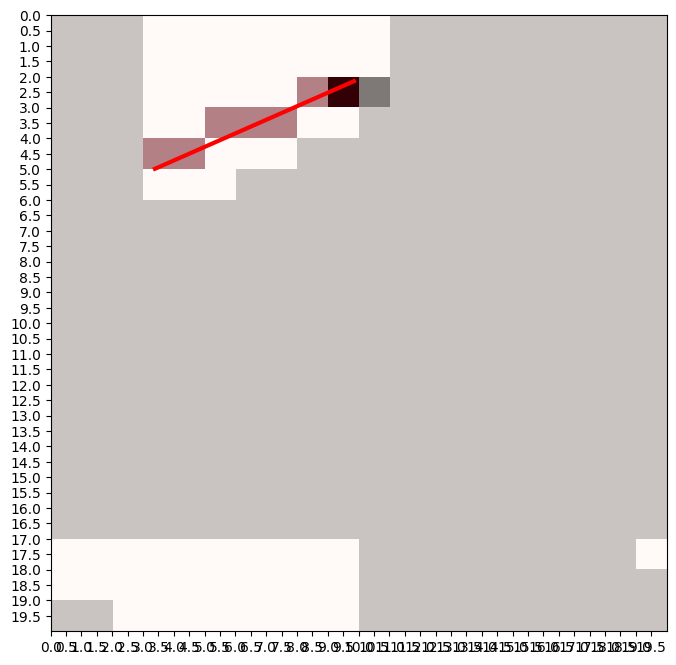

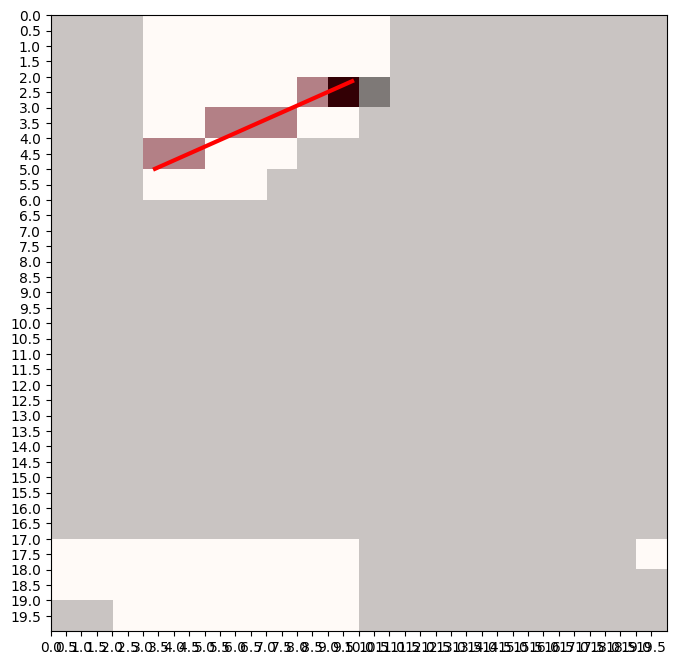

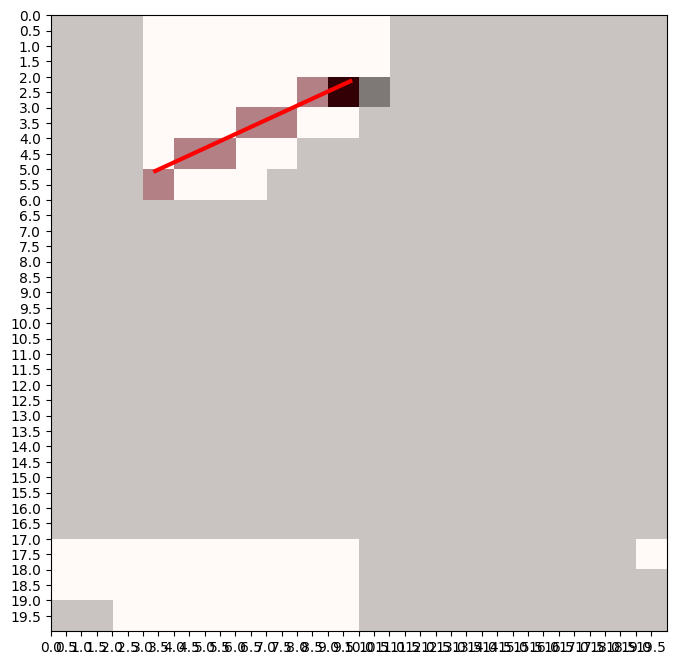

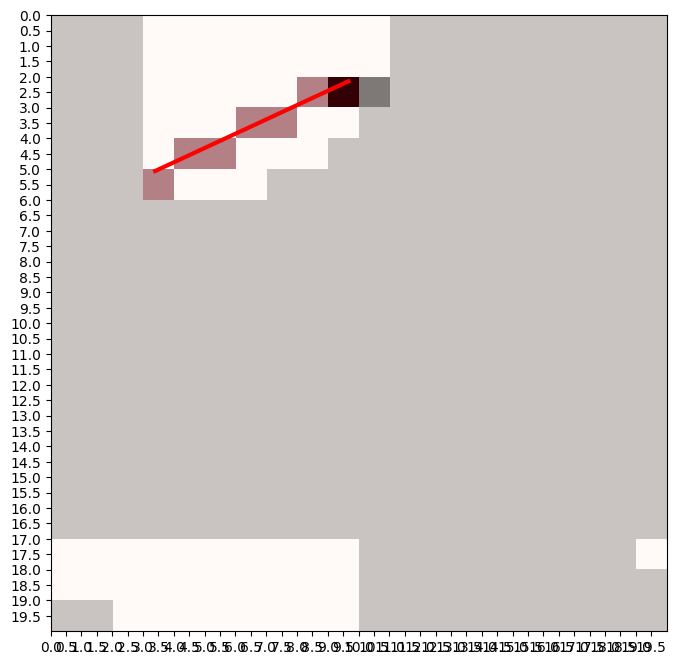

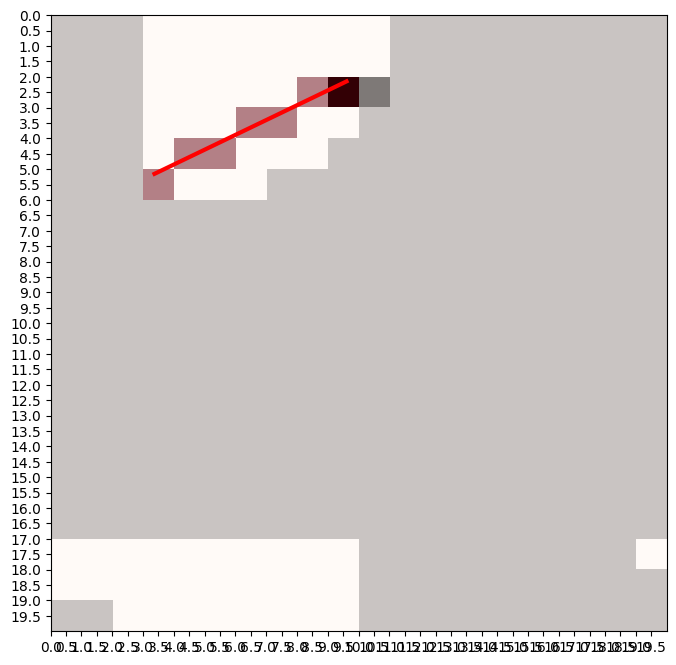

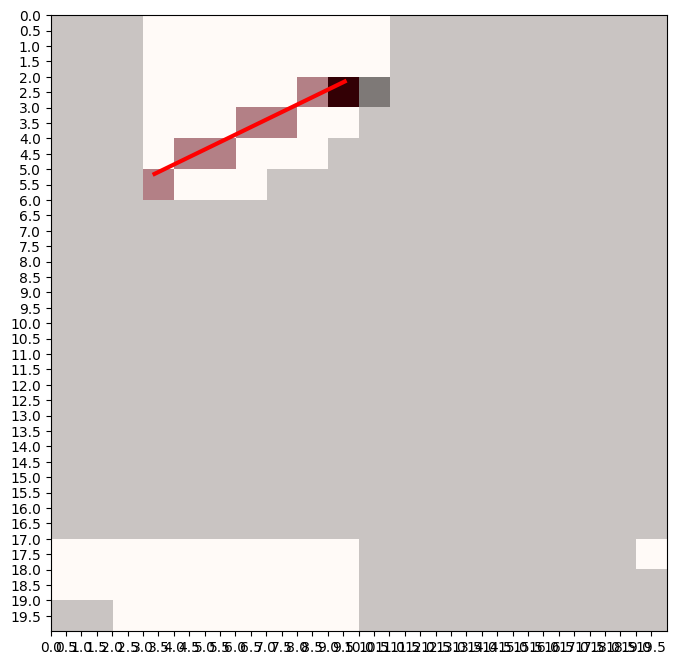

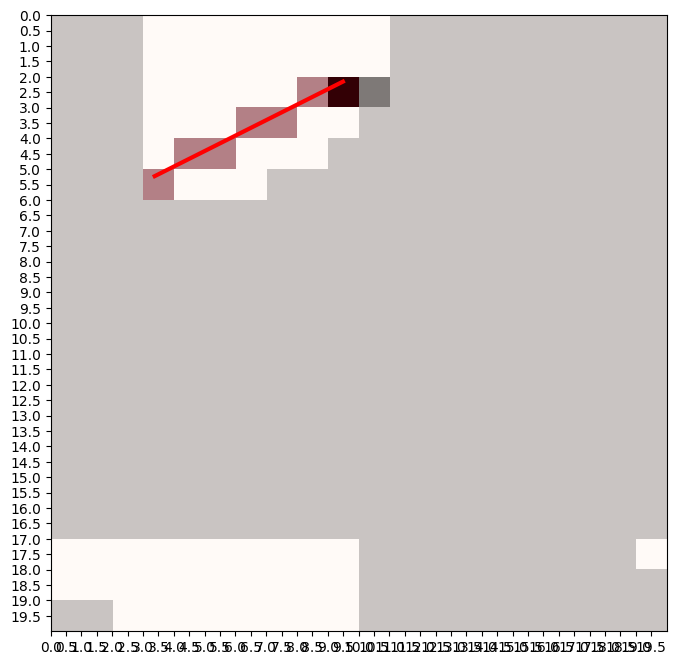

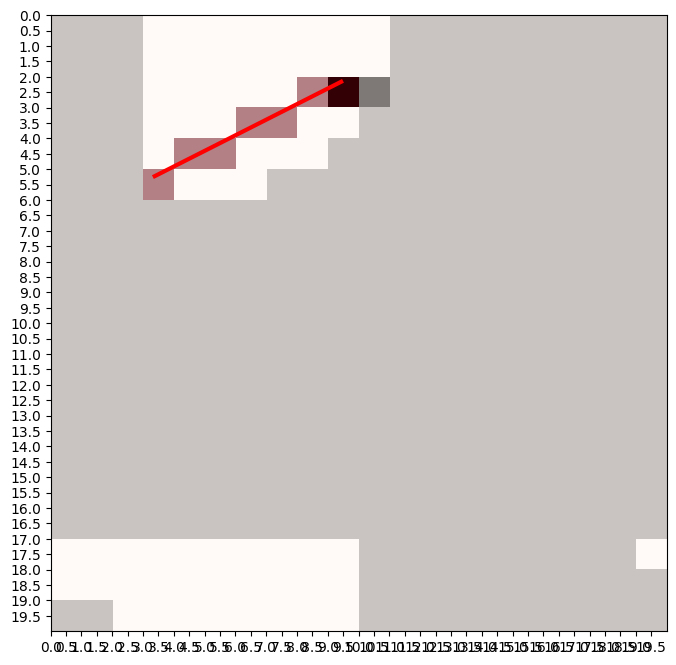

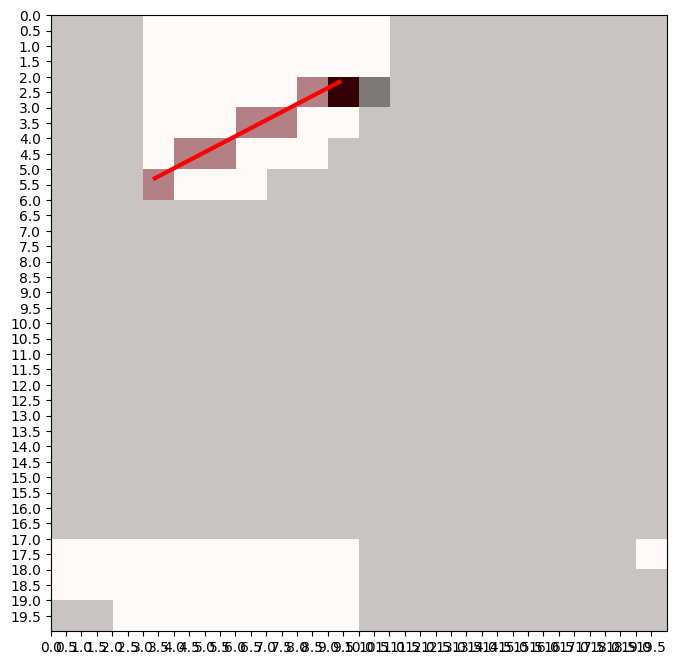

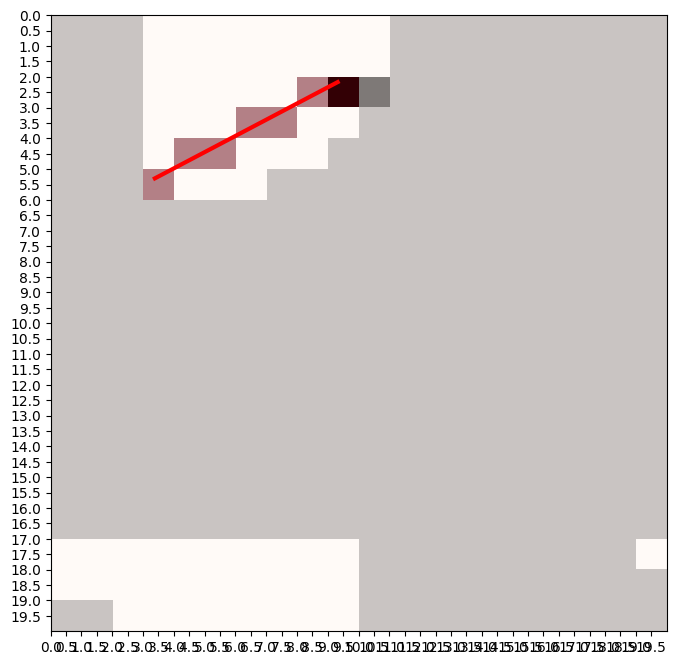

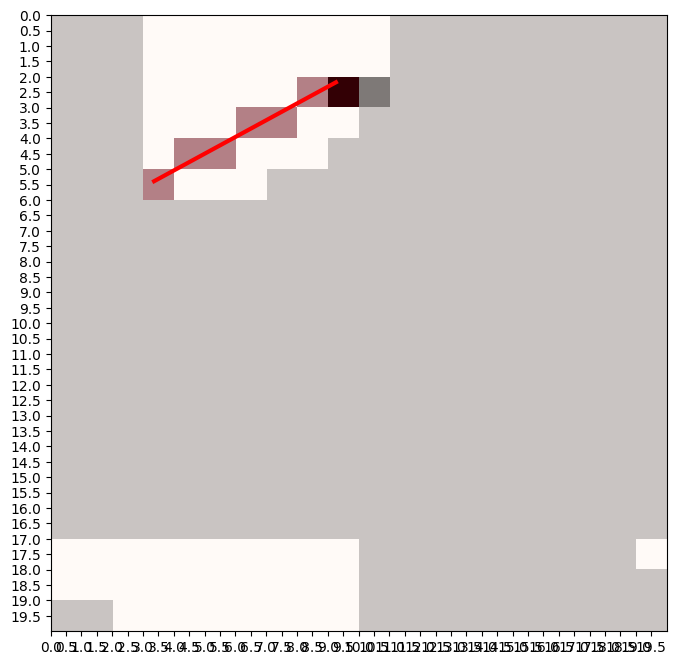

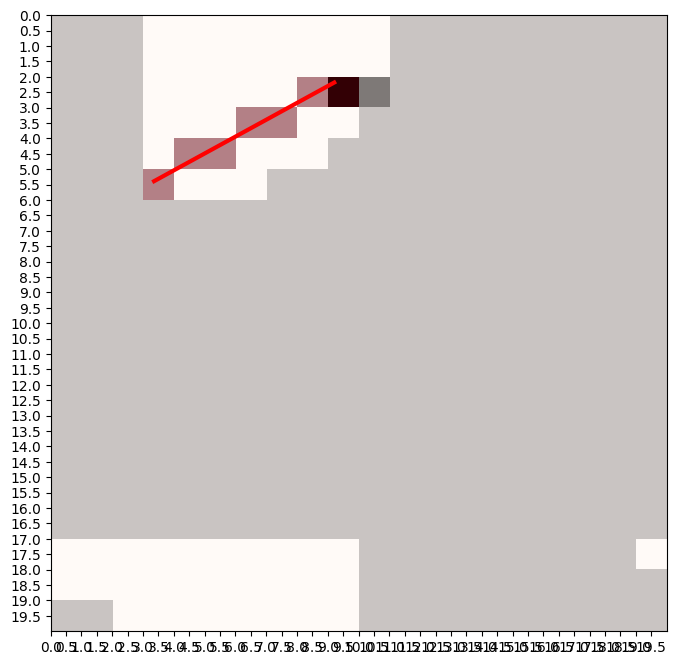

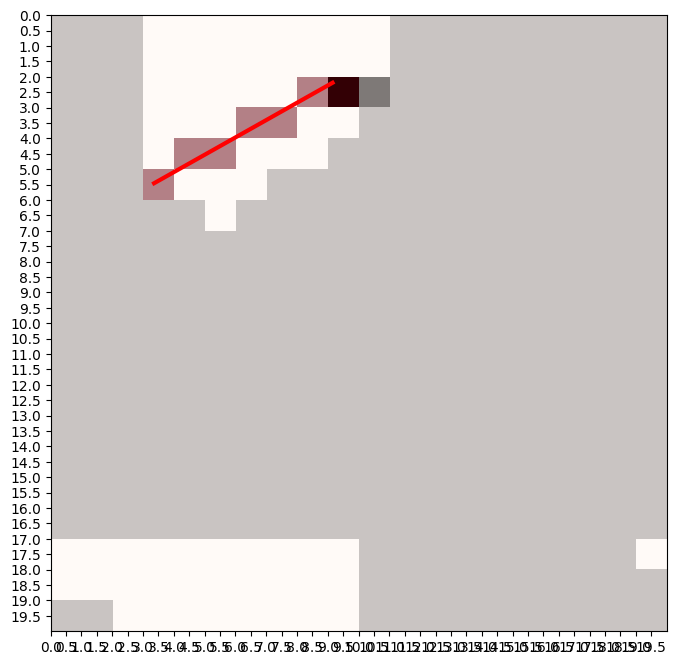

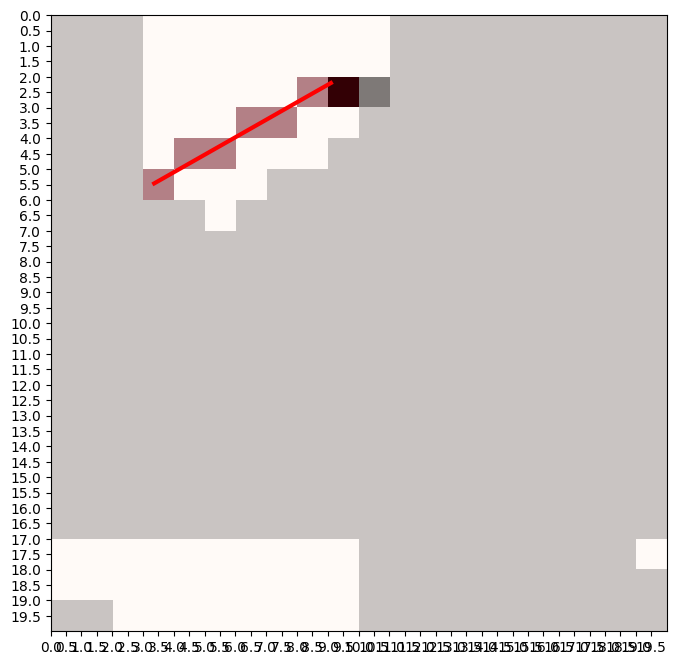

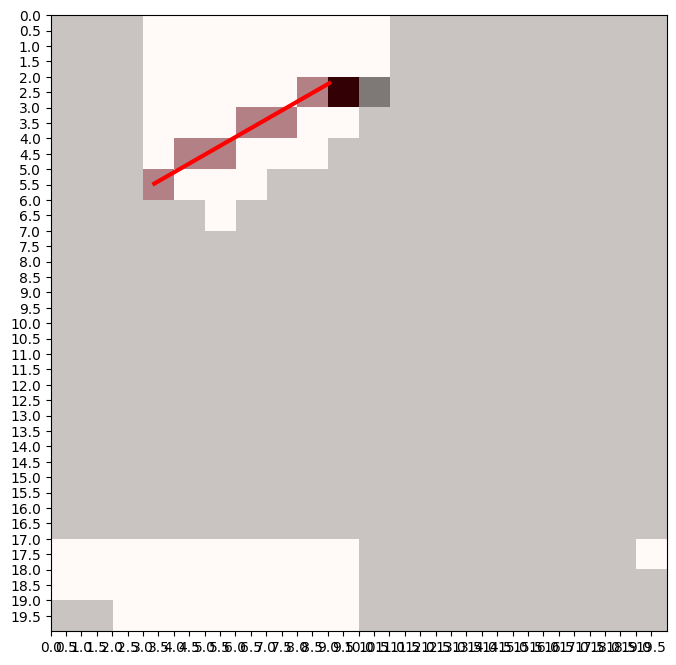

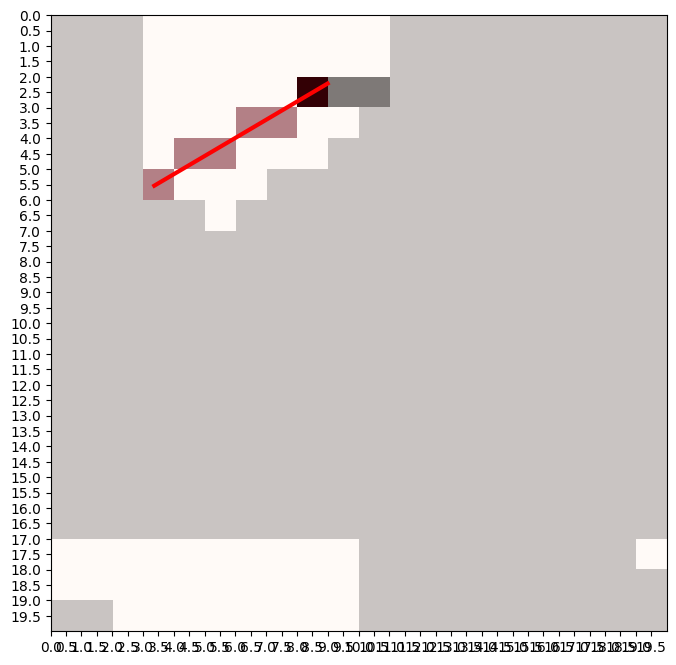

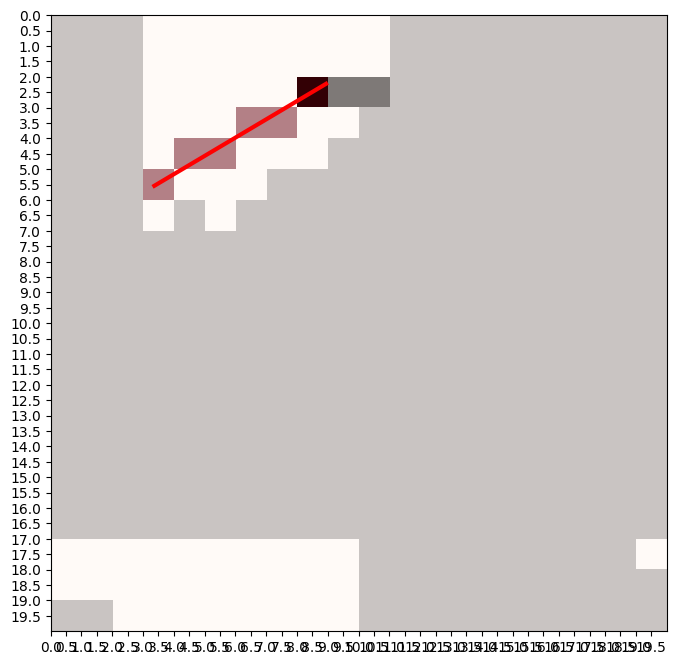

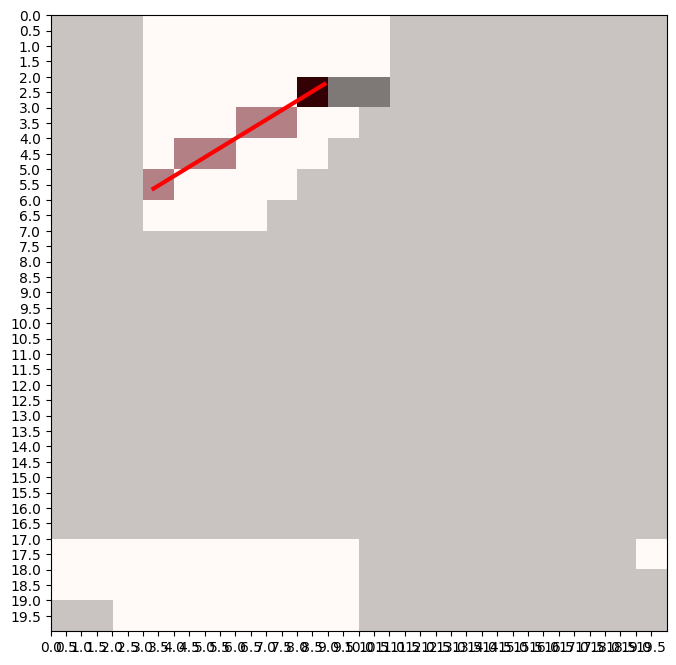

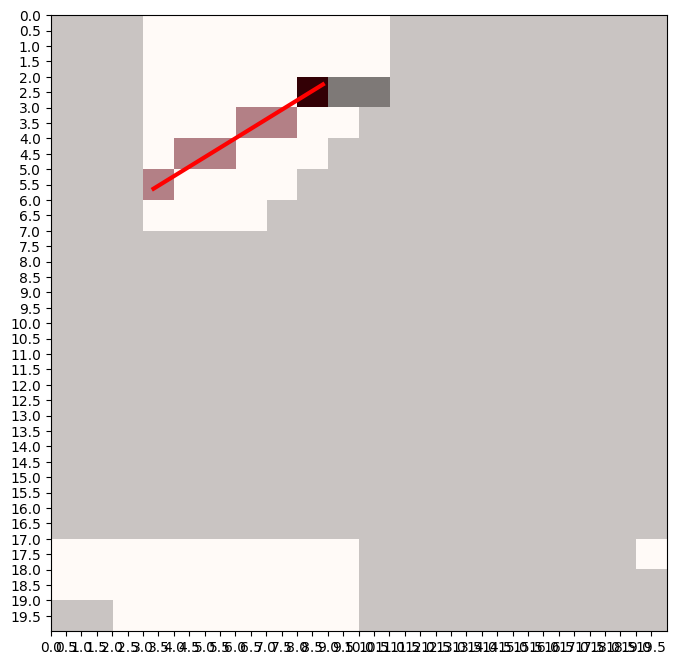

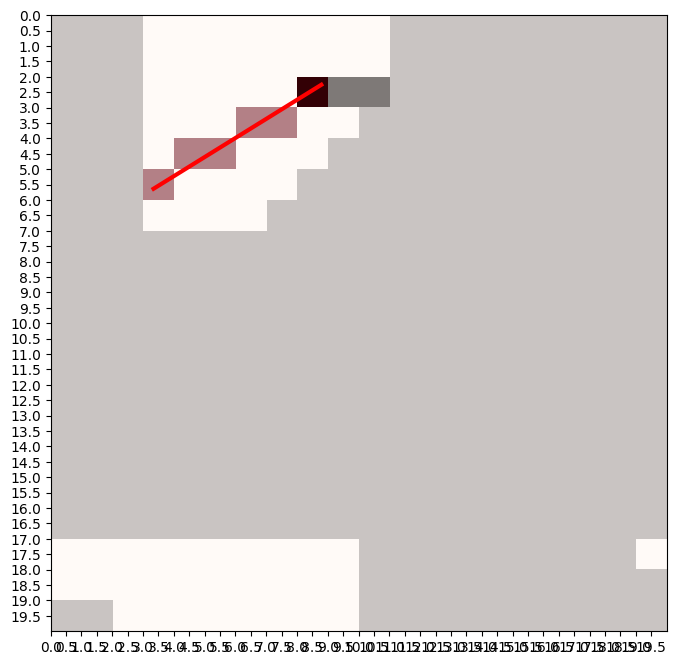

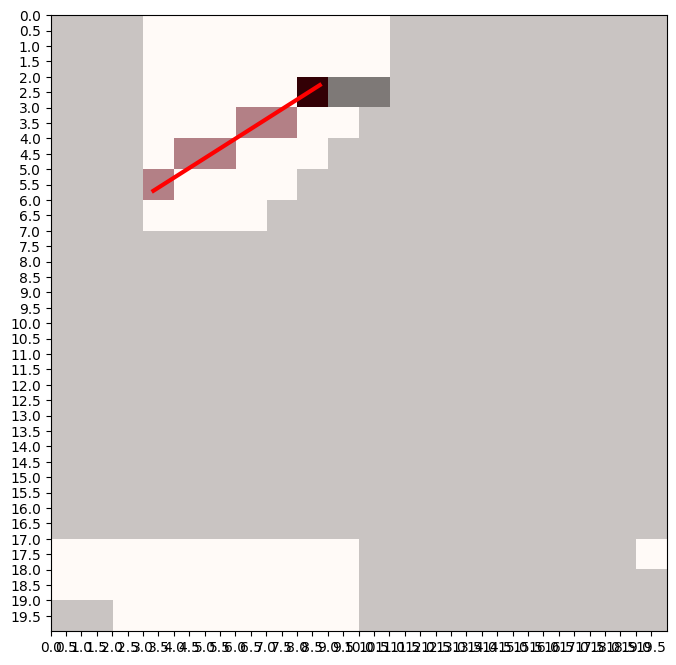

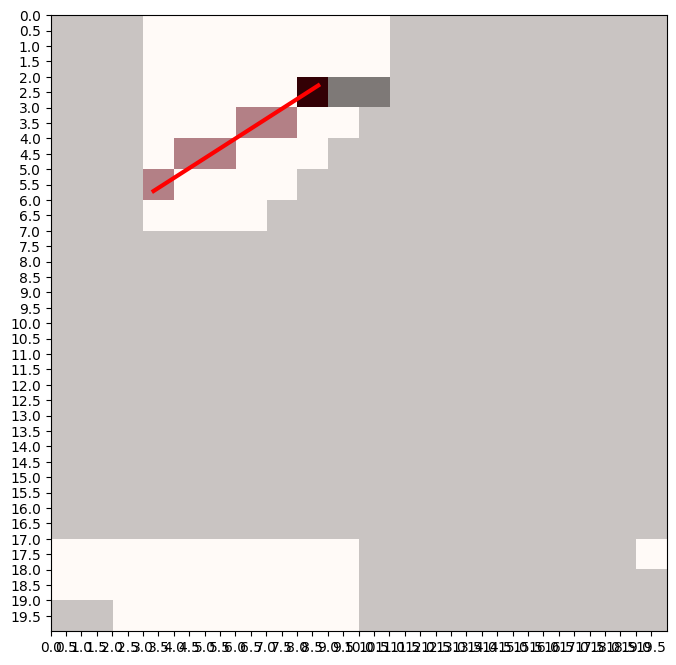

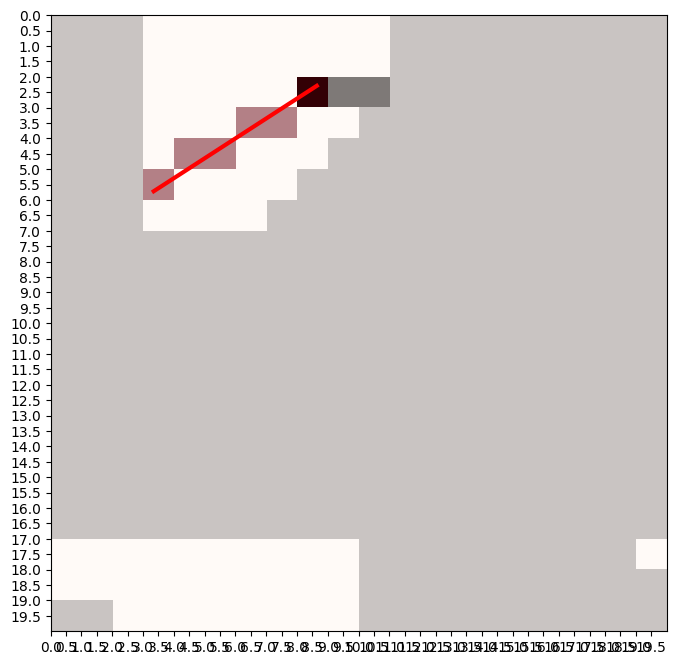

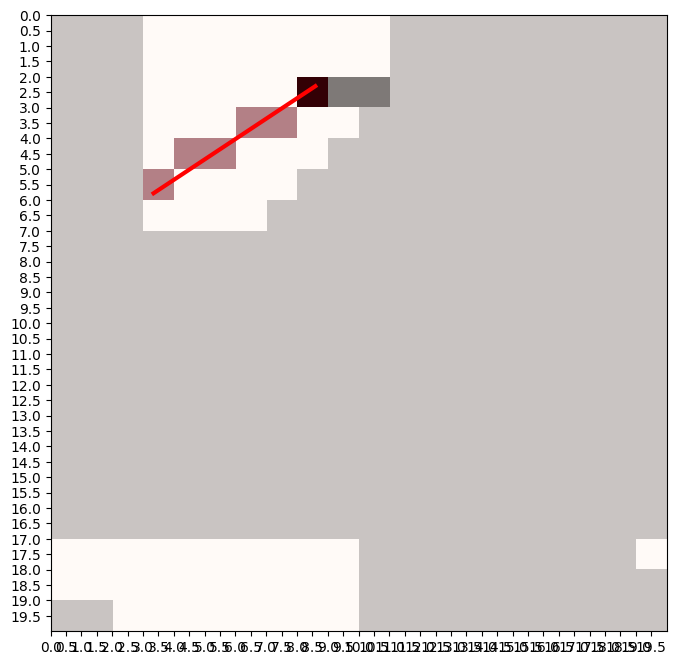

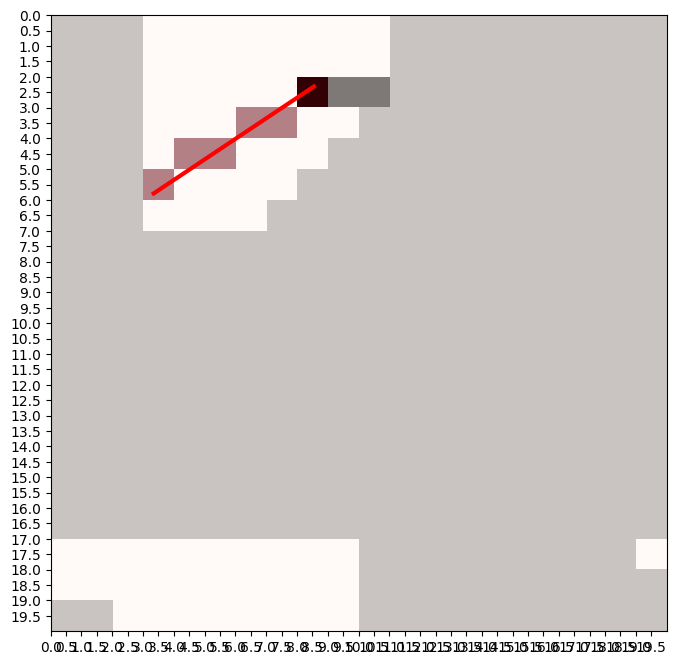

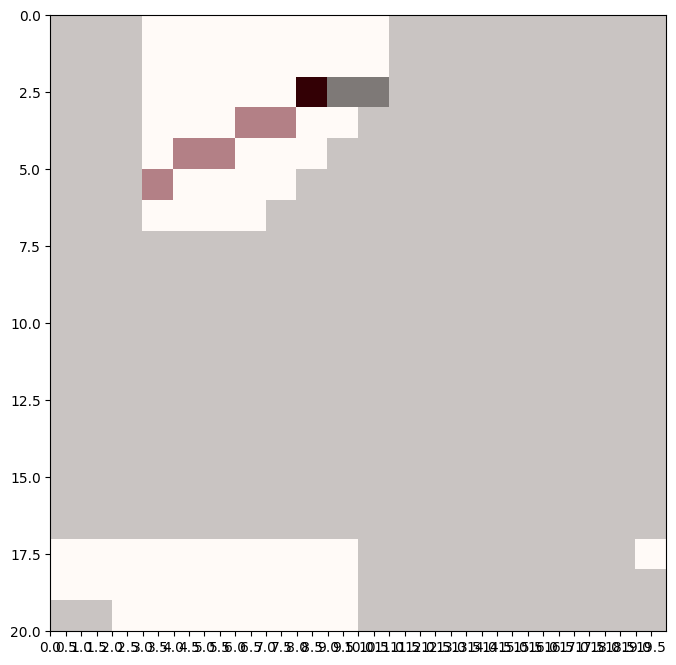

In [38]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

# caminho e nome do arquivo da cena
current_path = os.getcwd()
scenesFolder = "/cenas"
scenesFolder = current_path + scenesFolder
selectedScene = "cena-tp3-estatico.ttt"

sim.loadScene(os.path.join(scenesFolder, selectedScene)+"@keepCurrent")
sim.startSimulation()
print ('Program started')

if clientID!=-1:
    print ('Connected to remote API server')

    referenceHandle = sim.getObject('/ReferenceFrame')     

    robotname = '/kobuki'
    robotHandle = sim.getObject(robotname)  

    # Handle para o Laser
    lasername = "/kobuki/fastHokuyo"
    laserHandle = sim.getObject(lasername)

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    range_data = None
    while range_data == None:
        range_data = sim.getStringSignal(laser_range_data)
        # sim.step() responsável por sincronizar com a emulação
        sim.step()

    # Específico do robô
    L = 0.230   # Metros
    r = 0.035   # Metros
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    rho = np.inf
    while rho > .05:
        # Prosseguindo com as leituras
        raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)

        laser_data = np.array([raw_angle_data, raw_range_data]).T

        robotPos = sim.getObjectPosition(robotHandle, referenceHandle)
        robotOri = sim.getObjectOrientation(robotHandle, referenceHandle)  
        print(robotPos)
   

        draw_laser_data_World_Ref(robotPos, laser_data, ax = ax)

        leftMotor = sim.getObject(robotname+'/kobuki_leftMotor')
        rightMotor = sim.getObject(robotname + '/kobuki_rightMotor')
            
        # Goal configuration (x, y, theta)
        qgoal = np.array([2, 2, np.deg2rad(90)])
        #qgoal = defineGoal(m)

        # Frame que representa o Goal
        goalFrame = sim.getObject('/Goal')     
        sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0],referenceHandle)
        sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], referenceHandle) 

    
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])
        
        dx, dy, dth = qgoal - robotConfig
        
        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-robotConfig[2] + np.arctan2(dy,dx))
        beta = normalizeAngle(qgoal[2] - np.arctan2(dy,dx))
        
        kr = 4 / 20
        ka = 8 / 20
        kb = -1.5 / 20
        
        # Alvo na parte de trás
        if abs(alpha) > np.pi/2:
            kr = -kr       
            
            # Se não ajustar a direção muda
            alpha = normalizeAngle(alpha-np.pi)
            beta = normalizeAngle(beta-np.pi)

        v = kr*rho
        w = ka*alpha + kb*beta
        
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)

        sim.setJointTargetVelocity(rightMotor, wr)
        sim.setJointTargetVelocity(leftMotor, wl)
        sim.step()


    sim.setJointTargetVelocity(rightMotor, 0)
    sim.setJointTargetVelocity(leftMotor, 0)

    # Now close the connection to CoppeliaSim:
    sim.stopSimulation()
    sim.step()

else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')